<a href="https://colab.research.google.com/github/adimyth/interesting_stuff/blob/master/text/spanish_english_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word Level Seq2Seq Model

Shamelessly, copied from [here](https://github.com/hlamba28/Word-Level-Eng-Mar-NMT/blob/master/WordLevelEngMarNMT.ipynb)

## Encoder
![Encoder](https://guillaumegenthial.github.io/assets/img2latex/seq2seq_vanilla_encoder.svg)

## Decoder
![Decoder](https://guillaumegenthial.github.io/assets/img2latex/seq2seq_vanilla_decoder.svg)


Stepwise, the decoder operates as - 
![Decoder Operation](https://i.imgur.com/sWRGsi4.png)

## Dataset
English to Spanish Conversion - http://www.manythings.org/anki/spa-eng.zip

In [1]:
!wget http://www.manythings.org/anki/spa-eng.zip

--2020-04-18 06:14:12--  http://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 2606:4700:3037::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4781548 (4.6M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   4.56M  11.8MB/s    in 0.4s    

2020-04-18 06:14:13 (11.8 MB/s) - ‘spa-eng.zip’ saved [4781548/4781548]



In [2]:
!unzip -l spa-eng.zip
!unzip spa-eng.zip

Archive:  spa-eng.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
     1441  2020-03-15 02:17   _about.txt
 18493172  2020-03-15 02:17   spa.txt
---------                     -------
 18494613                     2 files
Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 


In [0]:
import matplotlib.pyplot as plt
from itertools import islice
import math
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import string
from string import digits
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model

In [0]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

Disabling eager execution because all zeros mask raises some CuDNN kernel level issue. Refere [here](https://github.com/tensorflow/tensorflow/issues/33148)

In [0]:
%matplotlib inline
sns.set_style("whitegrid")

In [0]:
lines = pd.read_table('spa.txt', names=['english', 'spanish', 'attributes'])
# lines = pd.DataFrame({"english": ["Juan eats apples"], "spanish": ["Juan come manzanas"], "attributes": ""})

In [7]:
lines.shape

(123770, 3)

In [0]:
lines = lines.drop(columns=['attributes'])

In [0]:
for col in lines.columns:
    # lowercase
    lines[col] = lines[col].apply(lambda x: x.lower())
    # remove quotes
    lines[col] = lines[col].apply(lambda x: re.sub("'", "", x))
    # remove punctuations
    lines[col] = lines[col].apply(lambda x: ''.join(ch for ch in x if ch not in set(string.punctuation)))
    # remove numbers
    remove_digits = str.maketrans('', '', digits)
    lines[col] = lines[col].apply(lambda x: x.translate(remove_digits))
    # remove unnecessary spaces
    lines[col] = lines[col].apply(lambda x: x.strip())
    lines[col] = lines[col].apply(lambda x: re.sub(" +", " ", x))

In [0]:
# Add start and end tokens to target sequences
lines['spanish'] = lines['spanish'].apply(lambda x : 'START_ '+ x + ' _END')

In [0]:
pd.set_option('display.max_colwidth', 100)

In [12]:
lines.head(10)

,english,spanish
0,go,START_ ve _END
1,go,START_ vete _END
2,go,START_ vaya _END
3,go,START_ váyase _END
4,hi,START_ hola _END
5,run,START_ ¡corre _END
6,run,START_ ¡corran _END
7,run,START_ ¡corra _END
8,run,START_ ¡corred _END
9,run,START_ corred _END


## Creating Vocabulary
Create vocabulary of english and spanish words

In [13]:
# English Vocab
all_eng_words = set()
for eng in lines['english']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
print(f"English Vocab: {len(all_eng_words)}")

English Vocab: 13475


In [14]:
# Spanish Vocab
all_spa_words = set()
for spa in lines['spanish']:
    for word in spa.split():
        if word not in all_spa_words:
            all_spa_words.add(word)
print(f"Spanish Vocab: {len(all_spa_words)}")

Spanish Vocab: 27264


In [15]:
# Max Length of source sequence
lenght_list_eng=[]
for l in lines['english']:
    lenght_list_eng.append(len(l.split(' ')))
max_length_src = np.max(lenght_list_eng)
print(f"Max Length Sentence (English): {max_length_src}")

Max Length Sentence (English): 47


In [16]:
# Max Length of target sequence
lenght_list_spa=[]
for l in lines['spanish']:
    lenght_list_spa.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list_spa)
print(f"Max Length Sentence (Spanish): {max_length_src}")

Max Length Sentence (Spanish): 47


In [17]:
matches = [i for i, j in zip(lenght_list_eng, lenght_list_spa) if i == j]
print(f"Number of matches: {len(matches)} ({(len(matches)*100/lines.shape[0]):.2f})")

Number of matches: 13865 (11.20)


In [18]:
lines.head()

,english,spanish
0,go,START_ ve _END
1,go,START_ vete _END
2,go,START_ vaya _END
3,go,START_ váyase _END
4,hi,START_ hola _END


In [19]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_spa_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_spa_words)
num_encoder_tokens, num_decoder_tokens

(13475, 27264)

In [0]:
num_encoder_tokens += 1 # For zero padding
num_decoder_tokens += 1 # For zero padding

## Embedding

In [0]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [0]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [23]:
n_items = take(10, input_token_index.items())
for k,v in n_items:
    print(k, v)

a 1
aardvark 2
aardvarks 3
aaron 4
aback 5
abandon 6
abandoned 7
abandoning 8
abate 9
abated 10


In [24]:
n_items = take(10, target_token_index.items())
for k,v in n_items:
    print(k, v)

START_ 1
_END 2
a 3
aabe 4
aah 5
aaron 6
abajo 7
abandona 8
abandonada 9
abandonadas 10


In [0]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [26]:
lines = shuffle(lines)
lines.head(10)

,english,spanish
64110,ill show you that i am right,START_ voy a demostrarte que no estoy equivocado _END
21792,it wasnt real love,START_ esto no era amor verdadero _END
97869,tom could understand why mary was angry,START_ tom podía entender que mary estaba enfadada _END
20012,are you a policeman,START_ ¿eres policía _END
79341,i dont know when hell come here,START_ no sé cuando vendrá él aquí _END
51994,show me the photos please,START_ muéstrame las fotografías por favor _END
54258,he couldnt do such a thing,START_ él no pudo haber hecho algo así _END
58383,could you send me a brochure,START_ ¿podrías enviarme un folleto _END
39137,thats quite remarkable,START_ eso es bastante memorable _END
77823,tom offered to lend me the money,START_ tom ofreció pasarme el dinero _END


## Train-Test Split

In [0]:
X, y = lines["english"], lines["spanish"]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
X_train.shape, y_train.shape

((99016,), (99016,))

In [30]:
X_test.shape, y_test.shape

((24754,), (24754,))

## Generator

In [0]:
def generate_batch(X=X_train, y=y_train, batch_size=128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src), dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar), dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens), dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t < len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

## Teacher Forcing
Teacher forcing works by using the actual or expected output from the training dataset at the current time step `y(t)` as input in the next time step `X(t+1)`, rather than the output generated by the network.

Decoder is trained to turn the target sequences into the same sequences but offset by one timestep in the future, a training process called "teacher forcing" in this context. Effectively, the decoder learns to generate targets `[t+1...]` given targets `[...t]`, conditioned on the input sequence.


### Example - 
Suppose, we had only 1 sentence -
* `English` - Juan eats apples
* `Spanish` - Juan come manzanas

Hence, we had just 3 words in our English & 5 in Spanish vocabulary. 
```
English Vocabulary
{'apples': 1, 'eats': 2, 'juan': 3}

Spanish Vocabulary
{'START_': 1, '_END': 2, 'come': 3, 'juan': 4, 'manzanas': 5}
```

So our encoded input & decoder input would look like - 
```
Encoder Input Data: [[3. 2. 1.]]

Decoder Input Data: [[1. 4. 3. 5. 0.]]
```

As the target sentence has 5 words, at timestep `t` during training, we set the previous timestep's `t-1` actual output to 1. So essentially, we will have 5 target sentence.

```
Decoder Target Data: 
[0. 0. 0. 0. 1. 0.] # juan
[0. 0. 0. 1. 0. 0.] # come
[0. 0. 0. 0. 0. 1.] # manzanas
[0. 0. 1. 0. 0. 0.] # _END
[0. 0. 0. 0. 0. 0.]
```

### Summary
TS1 -
```
Encoder Input Data - [3. 2. 1.]
Decoder Input Data: [1. 4. 3. 5. 0.]
Decoder Target Data: [0. 0. 0. 0. 1. 0.] # juan
```

TS2 -
```
Encoder Input Data - [3. 2. 1.]
Decoder Input Data: [1. 4. 3. 5. 0.]
Decoder Target Data: [0. 0. 0. 1. 0. 0.] # juan come
```

TS3 -
```
Encoder Input Data - [3. 2. 1.]
Decoder Input Data: [1. 4. 3. 5. 0.]
Decoder Target Data: [0. 0. 0. 0. 0. 1.] # juan come manzanas
```

TS4 -
```
Encoder Input Data - [3. 2. 1.]
Decoder Input Data: [1. 4. 3. 5. 0.]
Decoder Target Data: [0. 1. 0. 0. 0. 0.] # juan come manzanas _END
```


In [0]:
# batch_size = 1

# for j in range(0, len(X), batch_size):
#     encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
#     decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
#     decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
#     for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
#         for t, word in enumerate(input_text.split()):
#             print(f"Input: {word}")
#             encoder_input_data[i, t] = input_token_index[word] # encoder input seq
#         for t, word in enumerate(target_text.split()):
#             print(f"Target: {word}")
#             if t<len(target_text.split())-1:
#                 decoder_input_data[i, t] = target_token_index[word] # decoder input seq
#             if t>0:
#                 # decoder target sequence (one hot encoded)
#                 # does not include the START_ token
#                 # Offset by one timestep
#                 decoder_target_data[i, t - 1, target_token_index[word]] = 1.
#     print(f"Encoder Input Data: {encoder_input_data}") 
#     print(f"Decoder Input Data: {decoder_input_data}")
#     print(f"Decoder Target Data:\n {decoder_target_data}")
#     # print(f"Decoder Target Data:\n {decoder_target_data[:, :-1, :]}")

## Model

In [0]:
latent_dim = 50

In [0]:
# ENCODER
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(num_encoder_tokens, latent_dim, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

`mask_zero=True` - It treats '0' as a padding value. As per the docs, "If mask_zero is set to True, as a consequence, index 0 cannot be used in the vocabulary (input_dim should equal size of vocabulary + 1)". Which is why increased `num_encoder_tokens` & `num_decoder_tokens` in cell 20 

In [0]:
# set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(num_decoder_tokens, latent_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, dec_state_h, dec_state_c = decoder_lstm(dec_emb, initial_state=encoder_states)

In [0]:
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

Here, we add a Dense Layer that uses softmax activation on top of decoder. Notice, how for the sample sentence - `Juan eats apples`, the output target at each timestep looks like - 
```
[0. 0. 0. 0. 1. 0.] # juan
[0. 0. 0. 1. 0. 0.] # juan come
[0. 0. 0. 0. 0. 1.] # juan come manzanas
[0. 1. 0. 0. 0. 0.] # juan come manzanas _end
```
It is the job of the dense layer to predict this next word from the *decoder_outputs*

Model will take encoder inputs & decoder inputs and return decoder outputs

In [0]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

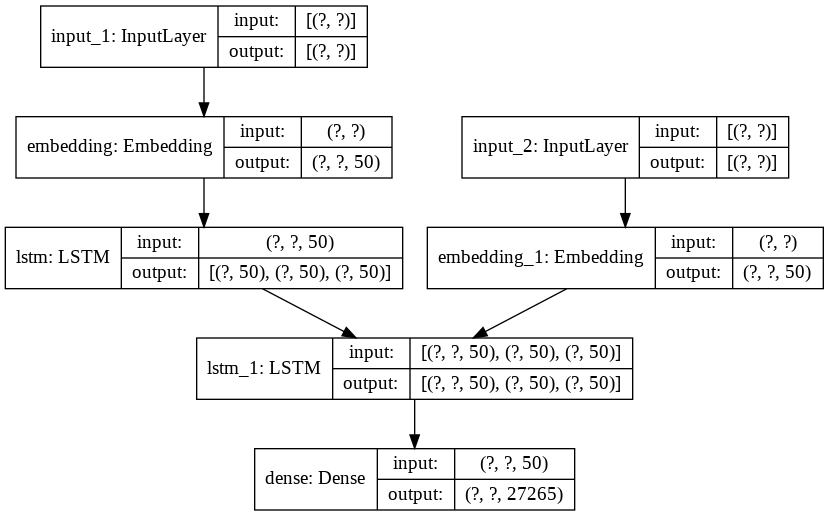

In [37]:
plot_model(model, show_shapes=True)

## Training

In [0]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 64
epochs = 20

In [107]:
model = load_model("english_to_spanish_nmt.h5")

In [108]:
history = model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size
                    )

Epoch 1/20
1547/1547 [==============================] - 587s 380ms/step - loss: 0.4378 - acc: 0.5534 - val_loss: 0.4848 - val_acc: 0.5001
Epoch 2/20
1547/1547 [==============================] - 585s 378ms/step - loss: 0.4350 - acc: 0.5568 - val_loss: 0.4841 - val_acc: 0.5006
Epoch 3/20
1547/1547 [==============================] - 586s 379ms/step - loss: 0.4323 - acc: 0.5600 - val_loss: 0.4833 - val_acc: 0.5024
Epoch 4/20
1547/1547 [==============================] - 584s 377ms/step - loss: 0.4296 - acc: 0.5631 - val_loss: 0.4818 - val_acc: 0.5026
Epoch 5/20
1547/1547 [==============================] - 583s 377ms/step - loss: 0.4269 - acc: 0.5660 - val_loss: 0.4810 - val_acc: 0.5035
Epoch 6/20
1547/1547 [==============================] - 584s 377ms/step - loss: 0.4242 - acc: 0.5688 - val_loss: 0.4805 - val_acc: 0.5042
Epoch 7/20
1547/1547 [==============================] - 583s 377ms/step - loss: 0.4216 - acc: 0.5715 - val_loss: 0.4800 - val_acc: 0.5050
Epoch 8/20
1547/1547 [============

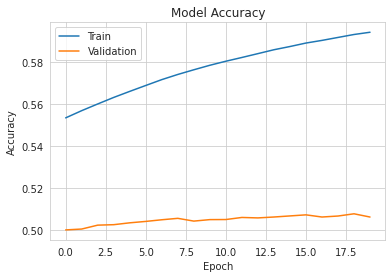

In [112]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

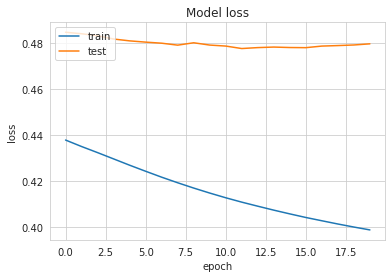

In [113]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.save("english_to_spanish_nmt.h5")

## Inference

***Encoder Setup***

Encode the input sequence to get the encoder_states - `state_h & state_c`

In [0]:
encoder_model = Model(encoder_inputs, encoder_states)

***Decoder setup***

Below tensors will hold the states of the previous time step. In case of the first sequence, assume - 
>1. decoder_state_input_c - state_c
>2. decoder_state_input_h - state_h


In [0]:
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

Get the embedding of decoder output sequences. For the first sequence, it will return the embedded vector for `START_` - [1., 0., 0., 0., 0.]. If the next predicted word is Juan, it will then return the embedded vector for `Juan` - [0., 0., 0., 1., 0.]

In [0]:
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero=True)
dec_emb2 = dec_emb_layer(decoder_inputs) 

To predict the next word in the sequence, set the initial states to the states from the previous time step


In [0]:
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)

Predict the next word in the sequence using the dense layer and choose the most probable word by selecting the word with most probability from the softmax probability distribution.

In [0]:
decoder_outputs2 = decoder_dense(decoder_outputs2) 

***Final Decoder Model***

Inputs -
>1. decoder_inputs - List of word
>2. decoder_states_inputs - previous timestep's hidden state & cell state

Outputs - 
>1. decoder_outputs2 - one-hot vector represeting the predicted word 
>2. decoder_states2 - current timestep's hidden state & cell state

In [0]:
decoder_states2 = [state_h2, state_c2]
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

## Decode Sequence

In [0]:
def decode_sequence(input_seq):
    probabilites = []
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sampling a token with max probability
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        probabilites.append(output_tokens[0, -1, :])

        # random sampling => gives vague results though
        # sampled_token_index = np.random.choice(range(len(output_tokens[0, -1, :])))

        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > max_length_tar):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

My attempt at using ***Beam Search Decoding*** using probabilites

In [0]:
def beam_search_decoder(predictions, top_k = 3):
    #start with an empty sequence with zero score
    output_sequences = [([], 0)]
    
    #looping through all the predictions
    for token_probs in predictions:
        new_sequences = []
        
        #append new tokens to old sequences and re-score
        for old_seq, old_score in output_sequences:
            for char_index in range(len(token_probs)):
                new_seq = old_seq + [char_index]
                #considering log-likelihood for scoring
                new_score = old_score + math.log(token_probs[char_index])
                new_sequences.append((new_seq, new_score))
                
        #sort all new sequences in the de-creasing order of their score
        output_sequences = sorted(new_sequences, key = lambda val: val[1], reverse = True)
        
        #select top-k based on score 
        # *Note- best sequence is with the highest score
        output_sequences = output_sequences[:top_k]
        
    return output_sequences

In [0]:
def decode_sequence_beam_search(input_seq):
    probabilites = []
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sampling a token with max probability
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        probabilites.append(output_tokens[0, -1, :])

        # random sampling => gives vague results though
        # sampled_token_index = np.random.choice(range(len(output_tokens[0, -1, :])))

        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > max_length_tar):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    # storing multiple results
    outputs = []
    beam_search_preds = beam_search_decoder(probabilites, top_k = 5)
    for prob_indexes, score in beam_search_preds:
        decoded_sentence = ''
        for index in prob_indexes:
            sampled_char = reverse_target_char_index[index]
            decoded_sentence += ' '+sampled_char
            if (sampled_char == '_END' or len(decoded_sentence) > max_length_tar):
                break
        outputs.append(decoded_sentence)

    return outputs

### Training Data

In [0]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [126]:
for _ in range(20):
    k+=1
    (input_seq, actual_output), _ = next(train_gen)
    decoded_sentence = decode_sequence(input_seq)
    print('Input Sentence:', X_train[k:k+1].values[0])
    print('Actual Translation:', y_train[k:k+1].values[0][6:-4])
    print('Predicted Translation:', decoded_sentence[:-4])
    print("="*30, end="\n\n")

Input Sentence: if you look around youll see many people doing the same thing
Actual Translation:  si ves a tu alrededor vas a ver a mucha gente haciendo lo mismo 
Predicted Translation:  si en en en en en en en en en en en en en mañana 

Input Sentence: are they gone
Actual Translation:  ¿se han marchado 
Predicted Translation:  se 

Input Sentence: he knows how to open this door
Actual Translation:  él sabe como abrir esta puerta 
Predicted Translation:  él el de de a 

Input Sentence: this history book is written for high school students
Actual Translation:  este libro de historia está escrito para estudiantes de secundaria 
Predicted Translation:  el el el la la la la la la la australia este ma

Input Sentence: i will get these shoes repaired by tomorrow
Actual Translation:  llevaré a arreglar estos zapatos antes de mañana 
Predicted Translation:  mañana mañana mañana mañana mañana mañana mañana ma

Input Sentence: the island is a paradise for children
Actual Translation:  la isla 

In [136]:
for _ in range(20):
    k+=1
    (input_seq, actual_output), _ = next(train_gen)
    decoded_sentences = decode_sequence_beam_search(input_seq)
    print('Input Sentence:', X_train[k:k+1].values[0])
    print('Actual Translation:', y_train[k:k+1].values[0][6:-4])
    for idx, pred in enumerate(decoded_sentences):
        print(f'Predicted Translation {idx}: {pred[:-4]}')
    print("="*30, end="\n\n")

Input Sentence: he knows how to open this door
Actual Translation:  él sabe como abrir esta puerta 
Predicted Translation 0:  un un 
Predicted Translation 1:  un 
Predicted Translation 2:  el un 
Predicted Translation 3:  la un 
Predicted Translation 4:  lo un 

Input Sentence: this history book is written for high school students
Actual Translation:  este libro de historia está escrito para estudiantes de secundaria 
Predicted Translation 0:  este este así así que que no no no 
Predicted Translation 1:  este este así así así que no no no 
Predicted Translation 2:  este este así así que así no no no 
Predicted Translation 3:  este este así así así así no no no 
Predicted Translation 4:  este este este así que que no no no 

Input Sentence: i will get these shoes repaired by tomorrow
Actual Translation:  llevaré a arreglar estos zapatos antes de mañana 
Predicted Translation 0:  que lo a a a 
Predicted Translation 1:  que a a a a 
Predicted Translation 2:  que lo que a a 
Predicted Tran

### Testing Data

In [0]:
val_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1

In [128]:
for _ in range(20):
    k+=1
    (input_seq, actual_output), _ = next(val_gen)
    decoded_sentence = decode_sequence(input_seq)
    print('Input Sentence:', X_test[k:k+1].values[0])
    print('Actual Translation:', y_test[k:k+1].values[0][6:-4])
    print('Predicted Translation:', decoded_sentence[:-4])
    print("="*30, end="\n\n")

Input Sentence: tom didnt have much food to eat
Actual Translation:  tom no tenía mucha comida para comer 
Predicted Translation:  tom no no no no no no no 

Input Sentence: they studied them closely
Actual Translation:  los estudiaron de cerca 
Predicted Translation:  ellos ellos 

Input Sentence: do you think im doing the right thing
Actual Translation:  ¿pensás que estoy haciendo lo correcto 
Predicted Translation:  no a que que que 

Input Sentence: i like cats more than dogs
Actual Translation:  a mí me gustan los gatos más que los perros 
Predicted Translation:  a como como la aprender la 

Input Sentence: tom wouldnt approve
Actual Translation:  tom no lo aprobaría 
Predicted Translation:  tom tom tom tom 

Input Sentence: i am fond of reading
Actual Translation:  me gusta leer libros 
Predicted Translation:  él la 

Input Sentence: the meeting was a little shorter than i expected it to be
Actual Translation:  la reunión fue algo más corta de lo que me había imaginado 
Predicted